Installing Libraries...

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy.integrate import solve_ivp

Base Parameter Setup

In [38]:
hours_in_a_day = 24
cell_behavior_rules = {
    "on_drug": {"r_S": -0.0015, "r_P": 0.0001 / hours_in_a_day, "r_R": 0.212651 / hours_in_a_day, "alpha": 0.0342, "beta": 0, "delta": 0.0186 / hours_in_a_day},
    "off_drug": {"r_S": 0.02, "r_P": -1 / (9 * hours_in_a_day), "r_R": 0.01 / hours_in_a_day, "alpha": 0, "beta": 1 / (9 * hours_in_a_day), "delta": 0}
}
starting_cell_counts = [1000000, 0, 0]
total_simulation_time_hours = 45 * hours_in_a_day
time_points_for_plot = np.linspace(0, total_simulation_time_hours, 1000)

Adaptive therapy model

In [39]:
def adaptive_therapy_model(t, y, threshold, rules):
    S, P, R = y
    r = rules["on_drug"] if S > threshold else rules["off_drug"]
    dS = r["r_S"] * S - r["alpha"] * S + r["beta"] * P
    dP = r["r_P"] * P + r["alpha"] * S - r["beta"] * P - r["delta"] * P
    dR = r["r_R"] * R + r["delta"] * P
    return [dS, dP, dR]

Sensitivity Analysis Setup

In [41]:
perturb_frac = 0.1 # 10% perturbation
parameters = [(g, p) for g in ["on_drug", "off_drug"] for p in ["r_S", "r_P", "r_R", "alpha", "beta", "delta"]]
base_rules = deepcopy(cell_behavior_rules)
threshold = 0.7 * starting_cell_counts[0] # Uses 70% of initial S cells as the adaptive therapy switching threshold. (Optimal Schedule)

# Baseline simulation
sol_base = solve_ivp(adaptive_therapy_model, [0, total_simulation_time_hours], starting_cell_counts,
                     t_eval=time_points_for_plot, args=(threshold, base_rules))
t_days = sol_base.t / hours_in_a_day
S_base, P_base, R_base = sol_base.y
outputs_base = {
    "AUC_R": np.trapz(R_base, t_days),
    "AUC_total": np.trapz(S_base + P_base + R_base, t_days),
    "Final_R": R_base[-1]
}

results = []

Perturbation Loop

In [30]:
for g, p in parameters:
    base_val = base_rules[g][p]
    if base_val == 0:
        print(f" Skipping {g}.{p} due to zero base value (avoiding division by zero).")
        continue
    for direction in [1 + perturb_frac, 1 - perturb_frac]:
        perturbed_rules = deepcopy(base_rules)
        perturbed_rules[g][p] = base_val * direction

        sol = solve_ivp(adaptive_therapy_model, [0, total_simulation_time_hours], starting_cell_counts,
                        t_eval=time_points_for_plot, args=(threshold, perturbed_rules))
        S, P, R = sol.y
        outputs_perturbed = {
            "AUC_R": np.trapz(R, t_days),
            "AUC_total": np.trapz(S + P + R, t_days),
            "Final_R": R[-1]
        }

        for o in outputs_base:
            sens = ((outputs_perturbed[o] - outputs_base[o]) / outputs_base[o]) / \
                   ((perturbed_rules[g][p] - base_val) / base_val)
            results.append({
                "Parameter": f"{g}.{p}",
                "Direction": "+10%" if direction > 1 else "-10%",
                "Output": o,
                "Sensitivity": sens
            })

 Skipping on_drug.beta due to zero base value (avoiding division by zero).
 Skipping off_drug.alpha due to zero base value (avoiding division by zero).
 Skipping off_drug.delta due to zero base value (avoiding division by zero).


Average +10% and -10% sensitivities

In [31]:
sdf = pd.DataFrame(results)
sdf_avg = sdf.groupby(["Parameter", "Output"], as_index=False)["Sensitivity"].mean()

Pivot safely

In [32]:
pivot = sdf_avg.pivot(index="Parameter", columns="Output", values="Sensitivity").sort_values(by="AUC_R", ascending=False)

Plot

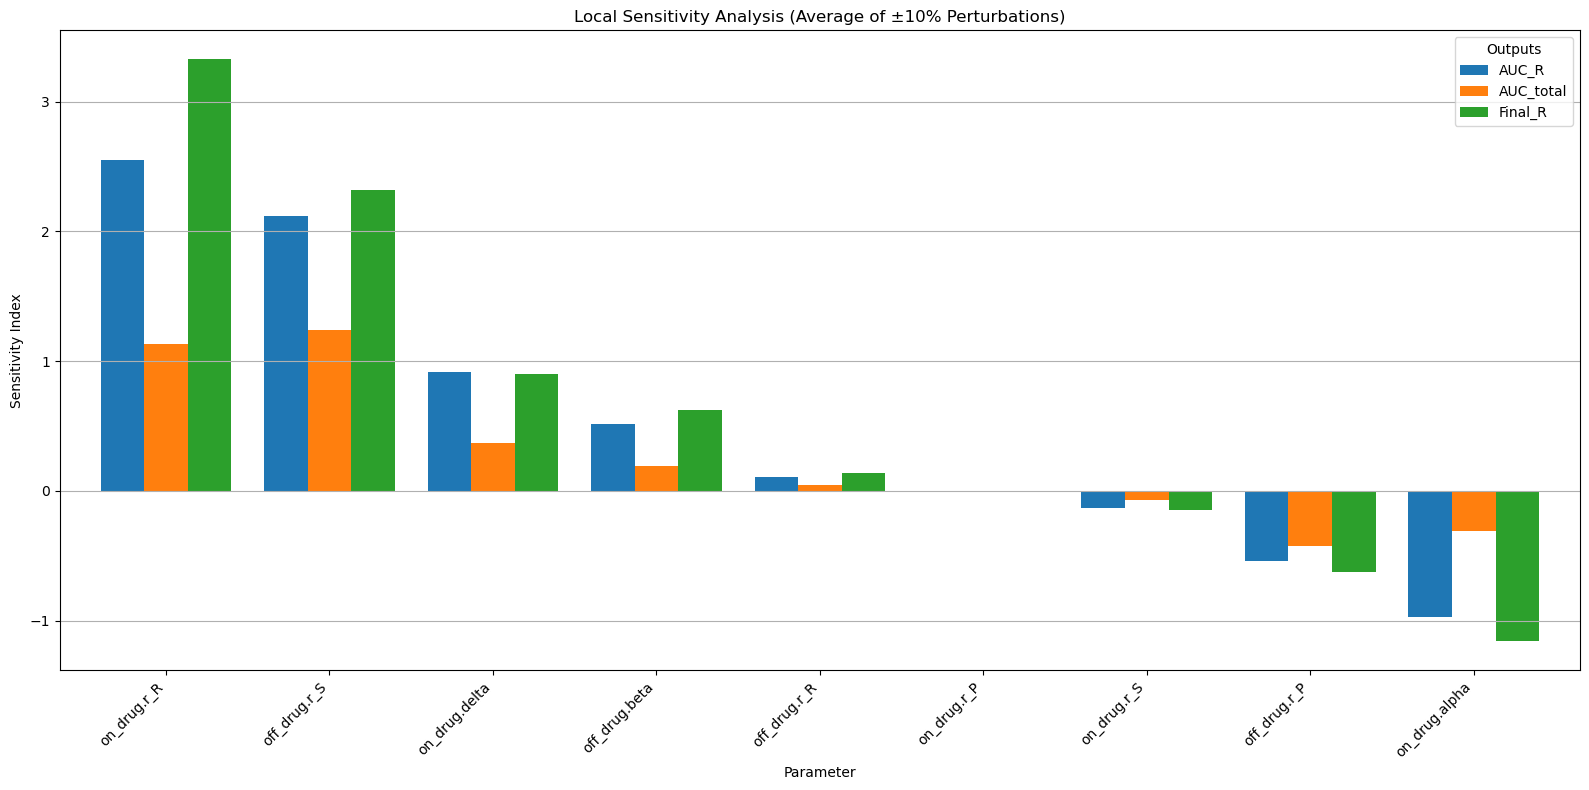

In [33]:
pivot.plot(kind="bar", figsize=(16, 8), width=0.8)
plt.title("Local Sensitivity Analysis (Average of ±10% Perturbations)")
plt.ylabel("Sensitivity Index")
plt.xlabel("Parameter")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.legend(title="Outputs")
plt.savefig("sensitivity_analysis_barplot.png", dpi=300)
plt.show()

Save Results

In [34]:
sdf_avg.to_csv("sensitivity_analysis_results.csv", index=False)
print(" Sensitivity analysis completed and saved as 'sensitivity_analysis_results.csv'.")

 Sensitivity analysis completed and saved as 'sensitivity_analysis_results.csv'.


***10% vs 20%***

Skipping on_drug.beta due to zero base value.
Skipping off_drug.alpha due to zero base value.
Skipping off_drug.delta due to zero base value.
Skipping on_drug.beta due to zero base value.
Skipping off_drug.alpha due to zero base value.
Skipping off_drug.delta due to zero base value.


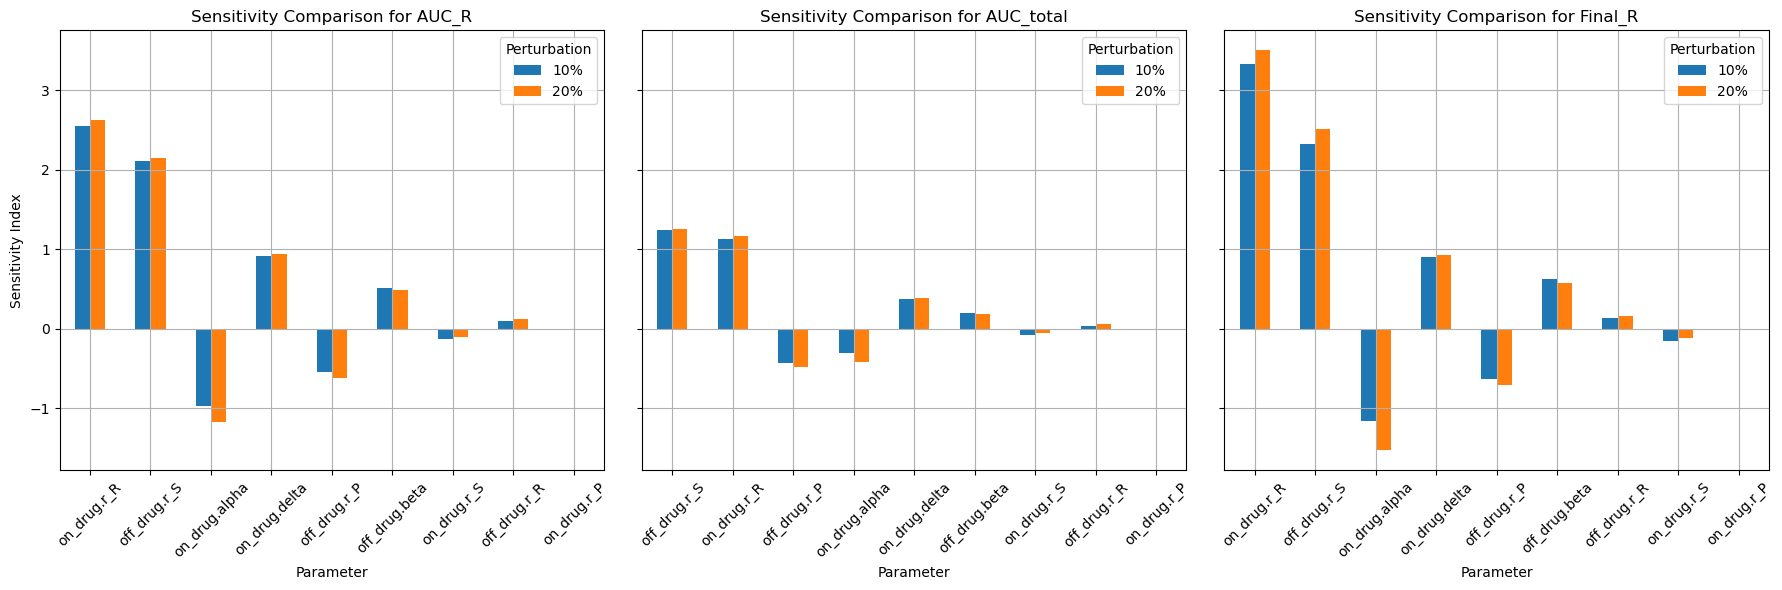

Comparative sensitivity plots saved as 'comparative_sensitivity_barplots.png'.
Sensitivity data saved as 'comparative_sensitivity_results.csv'.


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.integrate import solve_ivp

# Settings
hours_in_a_day = 24
cell_behavior_rules = {
    "on_drug": {
        "r_S": -0.0015,
        "r_P": 0.0001 / hours_in_a_day,
        "r_R": 0.212651 / hours_in_a_day,
        "alpha": 0.0342,
        "beta": 0,
        "delta": 0.0186 / hours_in_a_day
    },
    "off_drug": {
        "r_S": 0.02,
        "r_P": -1 / (9 * hours_in_a_day),
        "r_R": 0.01 / hours_in_a_day,
        "alpha": 0,
        "beta": 1 / (9 * hours_in_a_day),
        "delta": 0
    }
}
starting_cell_counts = [1_000_000, 0, 0]
total_simulation_time_hours = 45 * hours_in_a_day
time_points = np.linspace(0, total_simulation_time_hours, 1000)
threshold = 0.7 * starting_cell_counts[0]

def adaptive_therapy_model(t, y, threshold, rules):
    S, P, R = y
    r = rules["on_drug"] if S > threshold else rules["off_drug"]
    dS = r["r_S"] * S - r["alpha"] * S + r["beta"] * P
    dP = r["r_P"] * P + r["alpha"] * S - r["beta"] * P - r["delta"] * P
    dR = r["r_R"] * R + r["delta"] * P
    return [dS, dP, dR]

def compute_sensitivities(perturb_frac, tag):
    sol_base = solve_ivp(
        adaptive_therapy_model,
        [0, total_simulation_time_hours],
        starting_cell_counts,
        t_eval=time_points,
        args=(threshold, cell_behavior_rules)
    )
    t_days = sol_base.t / hours_in_a_day
    S_base, P_base, R_base = sol_base.y
    outputs_base = {
        "AUC_R": np.trapz(R_base, t_days),
        "AUC_total": np.trapz(S_base + P_base + R_base, t_days),
        "Final_R": R_base[-1]
    }

    parameters = [(grp, param) for grp in ["on_drug", "off_drug"]
                  for param in ["r_S", "r_P", "r_R", "alpha", "beta", "delta"]]
    results = []

    for grp, param in parameters:
        base_value = cell_behavior_rules[grp][param]
        if base_value == 0:
            print(f"Skipping {grp}.{param} due to zero base value.")
            continue
        for direction in [1 + perturb_frac, 1 - perturb_frac]:
            perturbed_rules = deepcopy(cell_behavior_rules)
            perturbed_rules[grp][param] = base_value * direction
            sol = solve_ivp(
                adaptive_therapy_model,
                [0, total_simulation_time_hours],
                starting_cell_counts,
                t_eval=time_points,
                args=(threshold, perturbed_rules)
            )
            S, P, R = sol.y
            outputs_pert = {
                "AUC_R": np.trapz(R, t_days),
                "AUC_total": np.trapz(S + P + R, t_days),
                "Final_R": R[-1]
            }

            for output in outputs_base.keys():
                numerator = (outputs_pert[output] - outputs_base[output]) / outputs_base[output]
                denominator = (perturbed_rules[grp][param] - base_value) / base_value
                sensitivity = numerator / denominator

                results.append({
                    "Parameter": f"{grp}.{param}",
                    "Output": output,
                    "Perturbation": f"{int(perturb_frac * 100)}%",
                    "Sensitivity": sensitivity
                })
    df = pd.DataFrame(results)
    return df

# Compute for 10% and 20%
df_10 = compute_sensitivities(0.10, "10pct")
df_20 = compute_sensitivities(0.20, "20pct")

# Merge for comparative plotting
df_combined = pd.concat([df_10, df_20])

# Prepare comparative grouped bar plot
outputs = ["AUC_R", "AUC_total", "Final_R"]
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, output in enumerate(outputs):
    df_plot = df_combined[df_combined["Output"] == output]
    pivot = df_plot.pivot_table(index="Parameter", columns="Perturbation", values="Sensitivity")
    pivot = pivot.loc[pivot.abs().max(axis=1).sort_values(ascending=False).index]  # sort by max abs sensitivity

    pivot.plot(kind="bar", ax=axs[idx])
    axs[idx].set_title(f"Sensitivity Comparison for {output}")
    axs[idx].set_xlabel("Parameter")
    axs[idx].set_ylabel("Sensitivity Index" if idx == 0 else "")
    axs[idx].tick_params(axis='x', rotation=45)
    axs[idx].grid(True)

plt.tight_layout()
plt.savefig("comparative_sensitivity_barplots.png", dpi=300)
plt.show()

# Save for your lab record
df_combined.to_csv("comparative_sensitivity_results.csv", index=False)
print("Comparative sensitivity plots saved as 'comparative_sensitivity_barplots.png'.")
print("Sensitivity data saved as 'comparative_sensitivity_results.csv'.")
